<a href="https://colab.research.google.com/github/neilghosh2000/CS6910_Assignment1/blob/main/CS6910_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [12]:
#import the data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


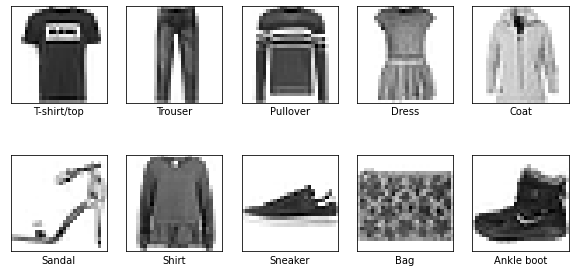

In [ ]:
# plot one sample image from each class arnesh
sample_images = []
plt.figure(figsize=(10,5))
for i in range(len(class_names)):
    sample_images.append(train_labels.tolist().index(i))
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[sample_images[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[sample_images[i]]])

In [13]:
def one_hot_vector(x):
  y = np.zeros((x.size, x.max()+1))
  y[np.arange(x.size),x] = 1
  return y

In [14]:
input_size = train_images.shape[1]*train_images.shape[2]
output_size = len(class_names)

train_x = train_images.reshape([train_images.shape[0], input_size, 1])/255
test_x = test_images.reshape([test_images.shape[0], input_size, 1])/255

train_y = one_hot_vector(train_labels)
test_y = one_hot_vector(test_labels)

train_y = np.dstack([train_y])
test_y = np.dstack([test_y])

In [15]:
nn_layers = [{"input_dim" : input_size, "output_dim" : 64, "activation" : "sigmoid"},
             {"input_dim" : 64, "output_dim" : 64, "activation" : "sigmoid"},
             {"input_dim" : 64, "output_dim" : 32, "activation" : "sigmoid"},
             {"input_dim" : 32, "output_dim" : output_size, "activation" : "sigmoid"}]
             
def init_layers(nn_layers, seed = 1):
    np.random.seed(seed)
    weights = {}

    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        weights['w' + str(layer_no)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        weights['b' + str(layer_no)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return weights

weights = init_layers(nn_layers)

In [16]:
def activation_func(z, activation="sigmoid"):
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif activation == "softmax":
        z1 = np.exp(z)
        z1 = z1.reshape([z1.shape[0], z1.shape[1]])
        return z1 / np.exp(z).sum(axis=1)
    elif activation == "tanh":
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    elif activation == "relu":
        return np.maximum(0, z)

    else:
        return "Error"

def activation_derivative(z, activation="sigmoid"):
    if activation == "sigmoid":
      sig = 1 / (1 + np.exp(-z))
      return sig*(1-sig)
    else:
      return "Error"

In [17]:
def forward_prop(train_x, weights, nn_layers):
    
    layer_output = {}
    h_curr = train_x
    
    layer_output["h0"] = train_x
    layer_output["a0"] = train_x
    
    for i, layer in enumerate(nn_layers):
        layer_no = i + 1
        h_prev = h_curr
        
        activation = layer["activation"]
        w_curr = weights["w" + str(layer_no)]
        b_curr = weights["b" + str(layer_no)]

        a_curr = np.matmul(w_curr, h_prev) + b_curr
        h_curr = activation_func(a_curr, activation)
        
        layer_output["a" + str(layer_no)] = a_curr
        layer_output["h" + str(layer_no)] = h_curr

    return h_curr, layer_output

In [ ]:
y_hat, layer_output = forward_prop(train_x, weights, nn_layers)

In [18]:
# cross entropy loss
def loss_func(y_hat, y):
  return (-np.multiply(y, np.log(y_hat)).sum())/len(y_hat)


def accuracy_func(y_hat, train_y):  
    correct_pred = np.argmax(y_hat, axis = 1) == np.argmax(train_y, axis = 1)
    return sum(bool(x) for x in correct_pred)/len(y_hat)

In [ ]:
loss_func(y_hat, train_y)

0.7433102758911755

In [19]:
def back_prop(y_hat, y, layer_output, weights, nn_layers):
    
    gradients = {}

    da_prev = -(y - y_hat)
    da_prev = np.dstack([da_prev])

    m = len(y_hat)
    
    for i, layer in reversed(list(enumerate(nn_layers))):
        layer_index = i + 1
        activation = layer["activation"]
        
        da_curr = da_prev
                   
        a_prev = layer_output["a" + str(i)]   
        h_prev = layer_output["h" + str(i)]
        dh_prev = np.zeros(h_prev.shape)
        
        a_curr = layer_output["a" + str(layer_index)]
        w_curr = weights["w" + str(layer_index)]
        b_curr = weights["b" + str(layer_index)]
        dw_curr = np.zeros(w_curr.shape)
        db_curr = np.zeros(b_curr.shape)

        for j in range(m):
            dw_curr += np.dot(da_curr[j], h_prev[j].T) 
            db_curr += da_curr[j]
            dh_prev[j] = np.dot(w_curr.T, da_curr[j])
        
        dw_curr /= m
        db_curr /= m
 
        da_prev = np.multiply(dh_prev,activation_derivative(a_prev, activation))
            
        gradients["dw" + str(layer_index)] = dw_curr
        gradients["db" + str(layer_index)] = db_curr
    
    return gradients

In [20]:
def gradient_descent(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers)

        for k, layer in enumerate(nn_layers):
          weights["w" + str(k+1)] -= eta * gradients["dw" + str(k+1)]        
          weights["b" + str(k+1)] -= eta * gradients["db" + str(k+1)]

        print(j)

    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " epochs completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list


In [21]:
def calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers):

    y_hat, layer_output = forward_prop(train_x, weights, nn_layers)
    training_loss = (loss_func(y_hat, train_y))
    training_accuracy = (accuracy_func(y_hat, train_y))

    y_hat, layer_output = forward_prop(test_x, weights, nn_layers)
    validation_loss = (loss_func(y_hat, test_y))
    validation_accuracy = (accuracy_func(y_hat, test_y))

    return training_loss, training_accuracy, validation_loss, validation_accuracy


In [22]:
def momentum_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  prev_weights = {}

  gamma = 0.9

  for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          prev_weights["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers)

        for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = gamma * prev_weights["w" + str(k+1)] + eta * gradients["dw" + str(k+1)]     
          prev_weights["b" + str(k+1)] = gamma * prev_weights["b" + str(k+1)] + eta * gradients["db" + str(k+1)]   

          weights["w" + str(k+1)] -= prev_weights["w" + str(k+1)]        
          weights["b" + str(k+1)] -= prev_weights["b" + str(k+1)]


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [23]:
def nesterov_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  prev_weights = {}
  look_ahead_w = {}
  
  gamma = 0.9

  for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          prev_weights["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  for i in range(epochs):
    for j in range(n_batches):

        for k, layer in enumerate(nn_layers):
          look_ahead_w["w" + str(k+1)] = weights["w" + str(k+1)] - gamma * prev_weights["w" + str(k+1)]
          look_ahead_w["b" + str(k+1)] = weights["b" + str(k+1)] - gamma * prev_weights["b" + str(k+1)]

        y_hat, layer_output = forward_prop(batch_x[j], look_ahead_w, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, look_ahead_w, nn_layers)

        for k, layer in enumerate(nn_layers):
          prev_weights["w" + str(k+1)] = gamma * prev_weights["w" + str(k+1)] + eta * gradients["dw" + str(k+1)]     
          prev_weights["b" + str(k+1)] = gamma * prev_weights["b" + str(k+1)] + eta * gradients["db" + str(k+1)]   

          weights["w" + str(k+1)] -= prev_weights["w" + str(k+1)]        
          weights["b" + str(k+1)] -= prev_weights["b" + str(k+1)]


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [24]:
def rmsprop(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}

  beta = 0.9
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  for i in range(epochs):
    for j in range(n_batches):

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers)

        for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = beta * v["w" + str(k+1)] + (1-beta) * gradients["dw" + str(k+1)]**2     
          v["b" + str(k+1)] = beta * v["b" + str(k+1)] + (1-beta) * gradients["db" + str(k+1)]**2   

          weights["w" + str(k+1)] -= eta * np.divide(gradients["dw" + str(k+1)], np.sqrt(v["w" + str(k+1)] + epsilon))        
          weights["b" + str(k+1)] -= eta * np.divide(gradients["db" + str(k+1)], np.sqrt(v["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [25]:
def adam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}
  v_hat = {}
  m = {}
  m_hat = {}

  beta1 = 0.9
  beta2 = 0.999
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)
          m["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          m["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  t = 0

  for i in range(epochs):
    for j in range(n_batches):

        t += 1

        y_hat, layer_output = forward_prop(batch_x[j], weights, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, weights, nn_layers)

        for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = beta2 * v["w" + str(k+1)] + (1-beta2) * gradients["dw" + str(k+1)]**2     
          v["b" + str(k+1)] = beta2 * v["b" + str(k+1)] + (1-beta2) * gradients["db" + str(k+1)]**2 

          m["w" + str(k+1)] = beta1 * m["w" + str(k+1)] + (1-beta1) * gradients["dw" + str(k+1)]    
          m["b" + str(k+1)] = beta1 * m["b" + str(k+1)] + (1-beta1) * gradients["db" + str(k+1)] 

          v_hat["w" + str(k+1)] = np.divide(v["w" + str(k+1)], (1-beta2**t))
          v_hat["b" + str(k+1)] = np.divide(v["b" + str(k+1)], (1-beta2**t))

          m_hat["w" + str(k+1)] = np.divide(m["w" + str(k+1)], (1-beta1**t))
          m_hat["b" + str(k+1)] = np.divide(m["b" + str(k+1)], (1-beta1**t))

          weights["w" + str(k+1)] -= eta * np.divide(m_hat["w" + str(k+1)], np.sqrt(v_hat["w" + str(k+1)] + epsilon))        
          weights["b" + str(k+1)] -= eta * np.divide(m_hat["b" + str(k+1)], np.sqrt(v_hat["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [26]:
def nadam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches):

  training_loss_list = []
  training_accuracy_list = []
  validation_loss_list = []
  validation_accuracy_list = []

  batch_x = np.array(np.array_split(train_x, n_batches))
  batch_y = np.array(np.array_split(train_y, n_batches))

  v = {}
  v_hat = {}
  m = {}
  m_hat = {}

  look_ahead_w = {}
  look_ahead_m_hat = {}
  look_ahead_v_hat = {}

  beta1 = 0.9
  beta2 = 0.999
  epsilon = 1e-8

  for k, layer in enumerate(nn_layers):
          v["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          v["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape)
          m["w" + str(k+1)] = np.zeros(weights["w" + str(k+1)].shape)    
          m["b" + str(k+1)] = np.zeros(weights["b" + str(k+1)].shape) 

  t = 0

  for i in range(epochs):
    for j in range(n_batches):

        t += 1

        for k, layer in enumerate(nn_layers):

          look_ahead_v_hat["w" + str(k+1)] = np.divide(beta2 * v["w" + str(k+1)], (1-beta2**t))
          look_ahead_v_hat["b" + str(k+1)] = np.divide(beta2 * v["b" + str(k+1)], (1-beta2**t))

          look_ahead_m_hat["w" + str(k+1)] = np.divide(beta1 * m["w" + str(k+1)], (1-beta1**t))
          look_ahead_m_hat["b" + str(k+1)] = np.divide(beta1 * m["b" + str(k+1)], (1-beta1**t))

          look_ahead_w["w" + str(k+1)] = weights["w" + str(k+1)] - eta * np.divide(look_ahead_m_hat["w" + str(k+1)], np.sqrt(look_ahead_v_hat["w" + str(k+1)] + epsilon))
          look_ahead_w["b" + str(k+1)] = weights["b" + str(k+1)] - eta * np.divide(look_ahead_m_hat["b" + str(k+1)], np.sqrt(look_ahead_v_hat["b" + str(k+1)] + epsilon))

        y_hat, layer_output = forward_prop(batch_x[j], look_ahead_w, nn_layers)
        gradients = back_prop(y_hat, batch_y[j], layer_output, look_ahead_w, nn_layers)

        for k, layer in enumerate(nn_layers):
          
          v["w" + str(k+1)] = beta2 * v["w" + str(k+1)] + (1-beta2) * gradients["dw" + str(k+1)]**2     
          v["b" + str(k+1)] = beta2 * v["b" + str(k+1)] + (1-beta2) * gradients["db" + str(k+1)]**2 

          m["w" + str(k+1)] = beta1 * m["w" + str(k+1)] + (1-beta1) * gradients["dw" + str(k+1)]    
          m["b" + str(k+1)] = beta1 * m["b" + str(k+1)] + (1-beta1) * gradients["db" + str(k+1)] 

          v_hat["w" + str(k+1)] = np.divide(v["w" + str(k+1)], (1-beta2**t))
          v_hat["b" + str(k+1)] = np.divide(v["b" + str(k+1)], (1-beta2**t))

          m_hat["w" + str(k+1)] = np.divide(m["w" + str(k+1)], (1-beta1**t))
          m_hat["b" + str(k+1)] = np.divide(m["b" + str(k+1)], (1-beta1**t))

          weights["w" + str(k+1)] -= eta * np.divide(m_hat["w" + str(k+1)], np.sqrt(v_hat["w" + str(k+1)] + epsilon))        
          weights["b" + str(k+1)] -= eta * np.divide(m_hat["b" + str(k+1)], np.sqrt(v_hat["b" + str(k+1)] + epsilon))


    training_loss, training_accuracy, validation_loss, validation_accuracy = calculate_loss_accuracy(train_x, train_y, test_x, test_y, weights, nn_layers)

    training_loss_list.append(training_loss)
    training_accuracy_list.append(training_accuracy)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)

    print((str(i+1)) + "/" + str(epochs) + " completed")

  return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [27]:
def train(train_x, train_y, test_x, test_y, nn_layers, epochs, eta, batch_size, optimizer):
    
    weights = init_layers(nn_layers)
    
    n_batches = len(train_x)//batch_size

    if optimizer == "gradient_descent":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = gradient_descent(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches)

    elif optimizer == "momentum_gradient_descent":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = momentum_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches)

    elif optimizer == "nesterov_accelerated_gradient_descent":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = nesterov_gd(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches)

    elif optimizer == "rmsprop":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = rmsprop(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches)

    elif optimizer == "adam":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = adam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches)

    elif optimizer == "nadam":
      weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list = nadam(train_x, train_y, test_x, test_y, weights, nn_layers, eta, epochs, n_batches)

    else:
      return "Error - Wrong Optimizer"
        
    return weights, training_loss_list, training_accuracy_list, validation_loss_list, validation_accuracy_list

In [28]:
eta = 0.001
epochs = 3
batch_size = 16

# batch_size = 1 for stochastic and batch_size = len(train_x) for batch updates

optimizer = ["gradient_descent", "momentum_gradient_descent", "nesterov_accelerated_gradient_descent", "rmsprop", "adam", "nadam"]

weights, train_loss, train_accuracy, validation_loss, validation_accuracy = train(train_x, train_y, test_x, test_y, nn_layers, epochs, eta, batch_size, optimizer[1])

# y_hat, layer_output = forward_prop(train_x, weights, nn_layers)

1/3 completed
2/3 completed
3/3 completed


In [30]:
train_loss

[2.2977850776303743, 2.2732213666201764, 1.7929710069200044]

In [31]:
train_accuracy

[0.11061666666666667, 0.30485, 0.2999]